In [26]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm

In [27]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def CSHam_ex(N, B, Ak, GS, Filling):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # now we add the extra gap filler
    #GS_s = scipy.sparse.csr_matrix(GS)
    #fill_Op = Filling * scipy.sparse.kron(GS_s, scipy.sparse.spmatrix.getH(GS_s))
    fill_Op = Filling * np.outer(GS, np.conj(GS))
    operators.append(fill_Op)
    sites.append(np.arange(0,N).tolist())
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization(hamiltonian):
    # Changes Hamiltonian to matrix form, where hamiltonian of interest is sparse in matrix form
    #haMatrix = hamiltonian.to_sparse()
    # Gets eigenvalues and vectors, where the built-in function uses 
    eigenValues, v = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)

    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err(state, edState, eng, edEng,N):
    engErr = np.abs(eng - edEng)
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return engErr, waveFunctionErr

In [28]:
# NetKet RBM with stochastic reconfiguration descent
class RBM:
    def __init__(self, N, hamiltonian, hilbertSpace, machine):
        # Assign inputsv[:, i]
        self.hamiltonian, self.hilbertSpace, self.machine, self.N = hamiltonian, hilbertSpace, machine, N
        # Define sampler
        self.sampler = nk.sampler.MetropolisLocal(hilbert=hilbertSpace)
        # Define optimizer
        self.optimizer = nk.optimizer.Sgd(learning_rate=0.05)
        # Define Stochastic reconfiguration
        self.sr = nk.optimizer.SR(diag_shift=0.01) #diagnol shift, its role as regularizer? seems to take a different form as 
        #compared to the version I have seen
        # Variational state
        self.vs = nk.variational.MCState(self.sampler, self.machine, n_samples=1000, n_discard=100) #discarded number of samples 
        #at the beginning of the MC chain

    # Output is the name of the output file in which the descent data is stored
    def __call__(self, output):
        self.vs.init_parameters(nk.nn.initializers.normal(stddev=0.25))
        gs = nk.VMC(hamiltonian=self.hamiltonian, optimizer=self.optimizer, variational_state=self.vs, sr=self.sr)
        # Start timing
        start = time.time()
        # Set the output files as well as number of iterations in the descent
        gs.run(out=output, n_iter=1000)
        end = time.time()
        runTime = end - start
        # Import the data from log file
        data = json.load(open(output + '.log'))
        # Extract the relevant information
        # iters = data["Energy"]["iters"]
        energy_RBM = data["Energy"]["Mean"]["real"] #get the real part of the mean energy
       
        # finalEng = energy_RBM[-1]
        finalEng = reduce(lambda x, y: x if y is None else y, energy_RBM)
        # Get machine statethe state of the machine as an array
        state = self.vs.to_array()
        # Outputs the final energy, the final state, and the runtime
        return finalEng, state, runTime
    
# Combines all steps into a function to run on the cluster
def runDescentCS_ex(N,B,Ak,alpha,GS,Filling, i):
    np.random.seed()
    # Define hamiltonian and hibert space (need to do this here cause can't use netket objects as input to use multiprocessing functions)
    ha, hi = CSHam_ex(N,B,Ak,GS,Filling)
    # RBM Spin Machine
    ma = nk.models.RBM(alpha=1, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
    # Initialize RBM
    rbm = RBM(N, ha, hi, ma) #an instance of class RBM
    # Run RBM
    eng, state, runTime = rbm("2021_summer_data/excited/var_ex_Logs"+str(N)+'run'+str(i)) #where _call_ will be invoked
    return eng, state, runTime

# Combines all steps into a function to run on the cluster
def runDescentCS(N,B,Ak,alpha):
    np.random.seed()
    # Define hamiltonian and hibert space (need to do this here cause can't use netket objects as input to use multiprocessing functions)
    ha, hi = CSHam(N,B,Ak)
    # RBM Spin Machine
    ma = nk.models.RBM(alpha=1, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
    # Initialize RBM
    rbm = RBM(N, ha, hi, ma) #an instance of class RBM
    # Run RBM
    eng, state, runTime = rbm("2021_summer_data/var_Logs"+str(N)) #where _call_ will be invoked
    return eng, state, runTime

In [29]:
import os
os.chdir('/home/victor')
os.getcwd()

'/home/victor'

In [47]:
# Here we find the different values of gap filling for testing
Ak = []
N = 5
B=0.95
# Variable A
A = N/2
N0 = N/2
for i in range(4):
        # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)

ha, hi = CSHam(N, B, Ak)

e,v  = exactDiagonalization_full(ha)
print('exact ground state is',e)
fill_1 = np.abs(e[1]-e[0])
fill_2 = fill_1 + 0.5 * np.abs(e[2]-e[1])
fill_3 = fill_1 + np.abs(e[2]-e[1])
fill_4 = np.abs(e[0]) + np.abs(e[-1]) + 1

filling = [fill_1, fill_2, fill_3, fill_4]
print(filling)

exact ground state is [-1.30151972 -1.19977677 -1.12441604 -1.06485203 -0.99958013 -0.90375854
 -0.89822616 -0.87881442 -0.67356913 -0.53568832 -0.41672184 -0.28178974
 -0.26054601 -0.11894047 -0.0312634   0.13021081  0.38243073  0.42627355
  0.44962725  0.4697751   0.47482643  0.48082165  0.54201127  0.65542376
  0.6822835   0.68896364  0.70614286  0.80363857  0.84415462  0.89824488
  0.97442331  1.08021081]
[0.1017429438325903, 0.1394233115705681, 0.17710367930854587, 3.3817305240077076]


In [31]:
N = 5
alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
#B=N/2
A = N/2
N0 = N/2
# List of Ak
Ak = []
for i in range(N - 1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)

#Exact Diagonalization
e, v = exactDiagonalization(ha)
#Ground state energy
edEng = e[0]
# Ground state
edState = v[0]

#Lists for Histogram Data
numRuns = 1
hisIt = np.arange(numRuns)
engErr = []
stateErr = []
runTime = []
GS = []

# Get errors for each run in histogram
for i in range(len(hisIt)):
    engTemp, stateTemp, runTimeTemp = runDescentCS(N,B,Ak,alpha)
    #engTemp, stateTemp, runTimeTemp = resultsSR[i]
    runTime.append(runTimeTemp)
    GS.append(stateTemp)
    errSR = err(np.asmatrix(stateTemp), edState, engTemp, edEng,N) #make state vector as matrix data-type
    engErr.append(errSR[0])
    stateErr.append(errSR[1])
    print('Eng error ', engErr)
    print('State error ', stateErr)
print(GS)


100%|██████████| 1000/1000 [00:18<00:00, 53.02it/s, Energy=-1.2993-0.0000j ± 0.0024 [σ²=0.0057, R̂=0.9981]]               


Eng error  [0.002169927230252666]
State error  [0.002922604191931355]
[DeviceArray([-3.04589036e-02+1.64999549e-02j,
             -6.04795648e-02-1.92550470e-02j,
             -9.28990030e-02-2.96821278e-02j,
             -2.27619273e-03-4.90002445e-03j,
             -1.47642491e-01-4.70308426e-02j,
             -2.86548932e-03-5.47397016e-03j,
             -3.36377658e-03-4.96559673e-03j,
             -1.72242807e-04-5.20449498e-04j,
             -2.39280863e-01-7.65987981e-02j,
             -3.85778213e-03-9.16958545e-03j,
             -3.11173948e-03-7.81159037e-03j,
             -3.60365604e-04-8.45294597e-04j,
             -5.08206896e-03-6.45267747e-03j,
             -2.00011770e-04-6.93483382e-04j,
             -1.74038499e-04-6.27000802e-04j,
             -2.50293624e-04-2.32223575e-04j,
              9.01780703e-01+2.88440177e-01j,
              1.13967701e-02+2.33227483e-02j,
              7.25902591e-03+1.75244152e-02j,
              2.64288848e-04+1.23049777e-03j,
         

In [48]:
N = 5
alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
#B=N/2
A = N/2
N0 = N/2
# List of Ak
Ak = []
for i in range(N - 1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
    
ha, hi = CSHam(N,B,Ak)    
e,v  = exactDiagonalization_full(ha)

#Ground state energy
edEng = e[1]
# Ground state
edState = v[1]

shit = [2,3]

for f_i in shit:  #here put N-1 (maximum)


    #Lists for Histogram Data
    numRuns = 50
    hisIt = np.arange(numRuns)
    engErr = []
    stateErr = []
    runTime = []
    
    
    
    # Get errors for each run in histogram
    for i in range(len(hisIt)):
        engTemp, stateTemp, runTimeTemp = runDescentCS_ex(N,B,Ak,alpha, GS[0], filling[f_i],i)
        #engTemp, stateTemp, runTimeTemp = resultsSR[i]
        runTime.append(runTimeTemp)
        errSR = err(np.asmatrix(stateTemp), edState, engTemp, edEng,N) #make state vector as matrix data-type
        engErr.append(errSR[0])
        stateErr.append(errSR[1])
        print('Eng error ', engErr)
        print('State error ', stateErr)

    #Save data to JSON file
    data = [engErr, stateErr, runTime]
    fileName = "2021_summer_data/Systematic_filling/var_N"+str(N)+"M" + str(M)+"fill"+str(f_i)+".json"
    open(fileName, "w").close()
    with open(fileName, 'a') as file:
        for item in data:
            line = json.dumps(item)
            file.write(line + '\n')
    print('SAVED')


  1%|          | 7/1000 [00:00<00:15, 62.19it/s, Energy=0.140-0.000j ± 0.023 [σ²=0.524, R̂=1.0117]]

Eng error  [0.0008831375678897135]
State error  [0.01740428620537582]


  1%|          | 7/1000 [00:00<00:16, 59.93it/s, Energy=-0.221-0.002j ± 0.025 [σ²=0.653, R̂=1.0048]]

Eng error  [0.0008831375678897135, 0.002311027995931303]
State error  [0.01740428620537582, 0.0012445956583790885]


  0%|          | 2/1000 [00:00<00:52, 19.12it/s, Energy=0.473+0.005j ± 0.012 [σ²=0.150, R̂=1.0006]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433]


  1%|          | 7/1000 [00:00<00:16, 60.16it/s, Energy=0.182-0.001j ± 0.023 [σ²=0.541, R̂=1.0051]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566]


  1%|          | 7/1000 [00:00<00:17, 56.73it/s, Energy=0.403-0.024j ± 0.022 [σ²=0.482, R̂=1.0045]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144]


  0%|          | 5/1000 [00:00<00:20, 48.01it/s, Energy=0.445-0.013j ± 0.020 [σ²=0.390, R̂=1.0104]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547]


  0%|          | 0/1000 [00:00<?, ?it/s, Energy=0.382+0.013j ± 0.020 [σ²=0.408, R̂=1.0160]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666]


  1%|          | 7/1000 [00:00<00:16, 58.91it/s, Energy=0.256-0.001j ± 0.022 [σ²=0.476, R̂=1.0090]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473]


  0%|          | 3/1000 [00:00<00:33, 29.91it/s, Energy=0.446-0.009j ± 0.020 [σ²=0.411, R̂=1.0008]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973]


  1%|          | 7/1000 [00:00<00:15, 63.27it/s, Energy=0.075-0.004j ± 0.020 [σ²=0.395, R̂=1.0016]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737]


  1%|          | 7/1000 [00:00<00:18, 52.84it/s, Energy=-0.323+0.003j ± 0.030 [σ²=0.889, R̂=0.9968]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614]


  1%|          | 7/1000 [00:00<00:17, 56.06it/s, Energy=0.348-0.006j ± 0.020 [σ²=0.406, R̂=1.0057]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375]


  0%|          | 0/1000 [00:00<?, ?it/s, Energy=0.560+0.004j ± 0.013 [σ²=0.168, R̂=1.0086]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524]


  0%|          | 0/1000 [00:00<?, ?it/s, Energy=0.548-0.003j ± 0.015 [σ²=0.227, R̂=1.0008]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525]


  0%|          | 5/1000 [00:00<00:20, 47.72it/s, Energy=0.072+0.006j ± 0.020 [σ²=0.414, R̂=1.0060]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096]


  1%|          | 7/1000 [00:00<00:19, 52.01it/s, Energy=0.529-0.008j ± 0.017 [σ²=0.306, R̂=1.0030]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405]


  1%|          | 7/1000 [00:00<00:15, 62.82it/s, Energy=0.125-0.021j ± 0.017 [σ²=0.282, R̂=1.0114]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093]


  1%|          | 7/1000 [00:00<00:16, 59.95it/s, Energy=0.407-0.009j ± 0.023 [σ²=0.526, R̂=1.0085]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524]


  1%|          | 7/1000 [00:00<00:16, 58.91it/s, Energy=0.522-0.002j ± 0.013 [σ²=0.173, R̂=1.0033]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.024998192670014907]


  1%|          | 7/1000 [00:00<00:16, 60.47it/s, Energy=-0.000+0.012j ± 0.026 [σ²=0.691, R̂=1.0102]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.024998192670014907, 0.020131240397629258]


  1%|          | 7/1000 [00:00<00:16, 60.36it/s, Energy=0.587-0.003j ± 0.015 [σ²=0.223, R̂=1.0051]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.024998192670014907, 0.020131240397629258, 0.005458554651929126]


  1%|          | 7/1000 [00:00<00:16, 59.49it/s, Energy=0.173-0.012j ± 0.018 [σ²=0.311, R̂=1.0009]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.024998192670014907, 0.020131240397629258, 0.005458554651929126, 

  1%|          | 7/1000 [00:00<00:16, 61.59it/s, Energy=0.131+0.001j ± 0.025 [σ²=0.629, R̂=1.0020]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.024998192670014907, 0.020131240397629258

  1%|          | 7/1000 [00:00<00:16, 58.52it/s, Energy=0.420-0.018j ± 0.020 [σ²=0.416, R̂=1.0040]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.0023902001883957524, 0.02499819267001490

  0%|          | 5/1000 [00:00<00:25, 39.78it/s, Energy=0.297-0.017j ± 0.017 [σ²=0.280, R̂=1.0087]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.011370952280803093, 0.00239020018839575

  1%|          | 7/1000 [00:00<00:16, 60.76it/s, Energy=0.239+0.002j ± 0.021 [σ²=0.461, R̂=1.0106]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415405, 0.0113709522808030

  1%|          | 6/1000 [00:00<00:21, 46.44it/s, Energy=0.523+0.004j ± 0.018 [σ²=0.344, R̂=1.0023]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.006316818569038096, 0.0021523741232415

  1%|          | 7/1000 [00:00<00:16, 60.16it/s, Energy=0.328+0.001j ± 0.025 [σ²=0.647, R̂=1.0011]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204525, 0.0063168185690380

  1%|          | 7/1000 [00:00<00:16, 60.20it/s, Energy=0.060-0.017j ± 0.029 [σ²=0.850, R̂=1.0032]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219524, 0.0075530470878204

  1%|          | 7/1000 [00:00<00:17, 56.84it/s, Energy=0.591-0.007j ± 0.020 [σ²=0.395, R̂=1.0037]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.004925453620458375, 0.005152315712219

  1%|          | 7/1000 [00:00<00:16, 60.87it/s, Energy=0.023+0.003j ± 0.026 [σ²=0.701, R̂=1.0061]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.003673277045455614, 0.00492545362045

  1%|          | 7/1000 [00:00<00:17, 57.56it/s, Energy=0.007-0.016j ± 0.023 [σ²=0.556, R̂=1.0038]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395354737, 0.0036732770454

  1%|          | 7/1000 [00:00<00:16, 61.33it/s, Energy=0.346+0.019j ± 0.018 [σ²=0.344, R̂=1.0081]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.025539250094781973, 0.02846832395

  1%|          | 7/1000 [00:00<00:16, 60.52it/s, Energy=-0.025+0.006j ± 0.026 [σ²=0.696, R̂=0.9993]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393544873473, 0.02553925009

  1%|          | 7/1000 [00:00<00:16, 59.37it/s, Energy=0.474+0.016j ± 0.015 [σ²=0.214, R̂=1.0015]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.023229535476467666, 0.0025872393

  1%|          | 7/1000 [00:00<00:16, 58.91it/s, Energy=0.003+0.030j ± 0.025 [σ²=0.634, R̂=1.0043]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984028216943547, 0.02322953

  1%|          | 7/1000 [00:00<00:16, 58.82it/s, Energy=0.503-0.010j ± 0.020 [σ²=0.395, R̂=0.9996]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.002764920345347144, 0.003984

  1%|          | 7/1000 [00:00<00:16, 60.14it/s, Energy=0.143-0.023j ± 0.025 [σ²=0.626, R̂=1.0039]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.008580017528369566, 0.00276

  1%|          | 7/1000 [00:00<00:16, 60.34it/s, Energy=0.313-0.001j ± 0.021 [σ²=0.455, R̂=1.0081]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586]
State error  [0.01740428620537582, 0.0012445956583790885, 0.0009438488307157433, 0.0085

  0%|          | 0/1000 [00:00<?, ?it/s, Energy=0.411+0.007j ± 0.017 [σ²=0.306, R̂=0.9975]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365]
State error  [0.01740428620537582, 0.0012445956583790885, 0.000

  1%|          | 7/1000 [00:00<00:16, 60.15it/s, Energy=0.152-0.002j ± 0.023 [σ²=0.512, R̂=1.0018]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146]
State error  [0.01740428620537582, 0.00

  1%|          | 7/1000 [00:00<00:17, 58.06it/s, Energy=0.220-0.041j ± 0.018 [σ²=0.345, R̂=1.0016]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833]
State error  [0.0

  1%|          | 7/1000 [00:00<00:17, 57.54it/s, Energy=0.021-0.012j ± 0.023 [σ²=0.535, R̂=1.0098]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:16, 61.22it/s, Energy=0.128-0.009j ± 0.027 [σ²=0.718, R̂=1.0142]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:15, 62.44it/s, Energy=0.169-0.008j ± 0.019 [σ²=0.375, R̂=1.0051]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:16, 58.66it/s, Energy=0.150+0.012j ± 0.024 [σ²=0.581, R̂=1.0038]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:16, 60.47it/s, Energy=0.077+0.020j ± 0.026 [σ²=0.686, R̂=1.0075]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:16, 59.03it/s, Energy=0.005-0.013j ± 0.026 [σ²=0.678, R̂=0.9997]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:16, 60.84it/s, Energy=0.236-0.012j ± 0.026 [σ²=0.680, R̂=1.0129]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:17, 57.99it/s, Energy=0.636-0.008j ± 0.016 [σ²=0.270, R̂=0.9988]]

Eng error  [0.0008831375678897135, 0.002311027995931303, 0.00026452146001521015, 0.001320034614386234, 0.0024588047036167016, 0.0007793924966075227, 0.0009526926271472558, 0.0001643607388532864, 0.0028382726691189575, 0.0023661330387541035, 0.002075977618206437, 0.0003120072460542911, 0.00011799174213988906, 0.0036281496214678466, 4.1991337809799134e-05, 0.00028444197312649244, 0.0021568735850523435, 0.0015102657258019292, 0.0042789488758960825, 0.0005307972572008435, 0.00024451176531137264, 0.0012305644136101357, 0.00015803625984323055, 0.0003837720828143709, 0.0015001440023079127, 0.0026845485425301963, 0.0036048367301169115, 0.004063187516268885, 0.0003698151093280977, 0.0004633346247640002, 0.0016987600469129394, 0.0012198982304358896, 0.0023916616923751466, 0.003287945946304438, 0.00019482304416884588, 3.3425123173280724e-05, 0.00040535787694540026, 0.0016086060471309782, 0.0025685370011958586, 0.00022514266797757365, 0.00011233054668036146, 0.004332981741829833, 0.001864263842104

  1%|          | 7/1000 [00:00<00:17, 57.62it/s, Energy=0.614+0.012j ± 0.013 [σ²=0.182, R̂=1.0039]]

Eng error  [0.00580380009669712]
State error  [0.013491160501204136]


  1%|          | 7/1000 [00:00<00:17, 56.75it/s, Energy=-0.037+0.002j ± 0.028 [σ²=0.811, R̂=1.0098]]

Eng error  [0.00580380009669712, 0.02877649347075817]
State error  [0.013491160501204136, 0.2131101316363142]


  1%|          | 6/1000 [00:00<00:20, 48.93it/s, Energy=0.351-0.006j ± 0.024 [σ²=0.560, R̂=1.0025]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722]


  1%|          | 7/1000 [00:00<00:17, 55.68it/s, Energy=0.462-0.004j ± 0.015 [σ²=0.234, R̂=1.0004]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432]


  1%|          | 7/1000 [00:00<00:17, 57.68it/s, Energy=0.648+0.006j ± 0.014 [σ²=0.206, R̂=1.0074]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049]


  1%|          | 7/1000 [00:00<00:17, 56.32it/s, Energy=0.303-0.019j ± 0.023 [σ²=0.519, R̂=1.0033]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377]


  1%|          | 7/1000 [00:00<00:16, 60.12it/s, Energy=0.214+0.001j ± 0.025 [σ²=0.650, R̂=1.0007]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903]


  1%|          | 7/1000 [00:00<00:16, 58.44it/s, Energy=0.347-0.004j ± 0.021 [σ²=0.437, R̂=1.0002]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225]


  0%|          | 3/1000 [00:00<00:35, 27.76it/s, Energy=0.578-0.006j ± 0.022 [σ²=0.476, R̂=0.9999]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507]


  1%|          | 7/1000 [00:00<00:17, 58.01it/s, Energy=0.312+0.010j ± 0.021 [σ²=0.455, R̂=1.0068]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936]


  1%|          | 7/1000 [00:00<00:17, 56.13it/s, Energy=0.094+0.003j ± 0.020 [σ²=0.421, R̂=1.0079]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003]


  1%|          | 7/1000 [00:00<00:16, 58.81it/s, Energy=0.187-0.008j ± 0.025 [σ²=0.642, R̂=1.0083]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108]


  1%|          | 7/1000 [00:00<00:17, 58.17it/s, Energy=0.216+0.019j ± 0.022 [σ²=0.508, R̂=0.9998]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525]


  1%|          | 7/1000 [00:00<00:17, 56.48it/s, Energy=0.554-0.002j ± 0.020 [σ²=0.407, R̂=0.9979]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253]


  1%|          | 7/1000 [00:00<00:17, 57.80it/s, Energy=-0.100-0.001j ± 0.027 [σ²=0.749, R̂=1.0084]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568]


  1%|          | 7/1000 [00:00<00:16, 59.99it/s, Energy=0.607-0.002j ± 0.015 [σ²=0.228, R̂=1.0036]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213]


  1%|          | 7/1000 [00:00<00:17, 56.54it/s, Energy=-0.224-0.013j ± 0.027 [σ²=0.730, R̂=1.0045]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559]


  1%|          | 7/1000 [00:00<00:18, 55.03it/s, Energy=0.584-0.004j ± 0.016 [σ²=0.268, R̂=0.9977]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197]


  1%|          | 7/1000 [00:00<00:18, 54.26it/s, Energy=0.260+0.008j ± 0.023 [σ²=0.534, R̂=1.0069]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053]


  1%|          | 7/1000 [00:00<00:18, 53.13it/s, Energy=0.360-0.012j ± 0.021 [σ²=0.446, R̂=1.0057]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053, 0.0028041572362640377]


  1%|          | 7/1000 [00:00<00:16, 58.82it/s, Energy=-0.168+0.000j ± 0.031 [σ²=0.942, R̂=1.0027]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053, 0.0028041572362640377, 0.0069447994707472205]


  1%|          | 7/1000 [00:00<00:17, 56.85it/s, Energy=0.515+0.012j ± 0.014 [σ²=0.201, R̂=0.9998]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053, 0.0028041572362640377, 0.0069447994707472205, 0.00450027031

  1%|          | 7/1000 [00:00<00:17, 57.64it/s, Energy=0.284+0.011j ± 0.021 [σ²=0.448, R̂=0.9980]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053, 0.0028041572362640377, 0.006944799470

  1%|          | 7/1000 [00:00<00:16, 58.58it/s, Energy=-0.007+0.018j ± 0.020 [σ²=0.418, R̂=0.9974]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714278053, 0.0028041572362

  1%|          | 7/1000 [00:00<00:17, 57.05it/s, Energy=0.052-0.014j ± 0.023 [σ²=0.526, R̂=1.0020]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.0030620893793216197, 0.003943057714

  1%|          | 7/1000 [00:00<00:17, 57.64it/s, Energy=0.458-0.002j ± 0.014 [σ²=0.199, R̂=1.0003]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568791559, 0.003062089379

  1%|          | 7/1000 [00:00<00:18, 53.75it/s, Energy=0.042-0.001j ± 0.028 [σ²=0.771, R̂=1.0020]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620785213, 0.006953153568

  1%|          | 7/1000 [00:00<00:17, 57.34it/s, Energy=0.063-0.024j ± 0.026 [σ²=0.658, R̂=1.0000]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.003728822983306568, 0.015258176620

  1%|          | 7/1000 [00:00<00:17, 57.23it/s, Energy=0.360+0.010j ± 0.023 [σ²=0.544, R̂=0.9971]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.0033112619717339253, 0.00372882298

  1%|          | 7/1000 [00:00<00:17, 55.53it/s, Energy=0.297+0.014j ± 0.024 [σ²=0.564, R̂=0.9990]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.004514851879903525, 0.003311261971

  1%|          | 7/1000 [00:00<00:16, 60.35it/s, Energy=0.384+0.026j ± 0.023 [σ²=0.544, R̂=1.0030]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702531154108, 0.0045148518

  1%|          | 7/1000 [00:00<00:17, 58.30it/s, Energy=0.198+0.004j ± 0.025 [σ²=0.647, R̂=0.9994]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.006107976658003, 0.0037712702

  0%|          | 0/1000 [00:00<?, ?it/s, Energy=0.101+0.001j ± 0.040 [σ²=1.612, R̂=1.0000]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.002858007161549936, 0.00610

  1%|          | 6/1000 [00:00<00:21, 45.69it/s, Energy=0.266+0.008j ± 0.028 [σ²=0.764, R̂=1.0023]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002667066822501507, 0.0028

  1%|          | 7/1000 [00:00<00:16, 58.47it/s, Energy=0.417-0.008j ± 0.020 [σ²=0.419, R̂=1.0044]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.005012908722133225, 0.002

  1%|          | 7/1000 [00:00<00:16, 59.68it/s, Energy=0.409+0.001j ± 0.016 [σ²=0.260, R̂=1.0025]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.036017824121908903, 0.00

  1%|          | 7/1000 [00:00<00:16, 61.75it/s, Energy=0.223+0.003j ± 0.023 [σ²=0.528, R̂=1.0018]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.011907733436140377, 0.0

  1%|          | 7/1000 [00:00<00:16, 58.76it/s, Energy=0.274+0.021j ± 0.037 [σ²=1.367, R̂=1.0038]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0.008398456061749049, 0.

  1%|          | 7/1000 [00:00<00:16, 58.96it/s, Energy=0.453+0.012j ± 0.025 [σ²=0.625, R̂=1.0026]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0.0027030346149592432, 0

  1%|          | 7/1000 [00:00<00:16, 60.60it/s, Energy=0.156+0.014j ± 0.021 [σ²=0.438, R̂=1.0084]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915]
State error  [0.013491160501204136, 0.2131101316363142, 0.0030918916284635722, 0

  1%|          | 7/1000 [00:00<00:17, 58.07it/s, Energy=0.267+0.016j ± 0.021 [σ²=0.428, R̂=1.0023]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866]
State error  [0.013491160501204136, 0.2131101316363142, 0.

  0%|          | 5/1000 [00:00<00:21, 46.90it/s, Energy=0.641+0.007j ± 0.012 [σ²=0.156, R̂=1.0048]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876]
State error  [0.013491160501204136, 0

  1%|          | 7/1000 [00:00<00:16, 59.36it/s, Energy=0.346-0.005j ± 0.019 [σ²=0.376, R̂=1.0022]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061]
State error  [0

  1%|          | 7/1000 [00:00<00:17, 57.34it/s, Energy=0.192+0.005j ± 0.022 [σ²=0.491, R̂=0.9978]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

  1%|          | 7/1000 [00:00<00:16, 59.38it/s, Energy=0.247-0.009j ± 0.029 [σ²=0.844, R̂=1.0012]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

  0%|          | 5/1000 [00:00<00:25, 38.97it/s, Energy=0.380+0.009j ± 0.020 [σ²=0.401, R̂=1.0073]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

  0%|          | 5/1000 [00:00<00:22, 44.53it/s, Energy=0.310-0.003j ± 0.027 [σ²=0.758, R̂=1.0078]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

  1%|          | 7/1000 [00:00<00:16, 59.58it/s, Energy=0.522+0.003j ± 0.017 [σ²=0.298, R̂=1.0001]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

  1%|          | 7/1000 [00:00<00:17, 56.66it/s, Energy=0.452+0.013j ± 0.020 [σ²=0.397, R̂=1.0029]]

Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

100%|██████████| 1000/1000 [00:30<00:00, 32.27it/s, Energy=-1.1908-0.0011j ± 0.0050 [σ²=0.0257, R̂=1.0035]]   


Eng error  [0.00580380009669712, 0.02877649347075817, 0.0017975562379344279, 2.084044474925939e-05, 0.006467333608483727, 5.075026899592494e-05, 0.003368951593674563, 0.0031239509339888727, 0.0004255706136135906, 0.0011993259681131185, 0.0009623526385917902, 0.00332171027367667, 0.00036732353133683837, 0.0007225785896962655, 0.003783071694368756, 0.001972419480688936, 0.0011933793117453462, 0.0007615589058918015, 0.004514721500180174, 0.00028090607705877346, 0.0016245958567038254, 0.0005133769327967386, 0.002858633038041125, 0.019924198489146727, 0.0002447627195836244, 0.0026968801216216143, 0.011920640521050796, 0.010041864508619991, 0.0004950652199648964, 0.008448729030545055, 0.00027934596044265625, 0.0024581764557718433, 0.00018979787704886952, 0.0012068275352514757, 0.0016666366079778339, 0.0006859638447240801, 0.0009219589357780666, 0.0011505465094356904, 0.0015994777205969868, 0.0005887324228774915, 0.056521058388487866, 0.00105099428723876, 0.002381326770372061, 0.0053643348250

In [49]:
#take half of the energy gap
avg_eng_er = []
avg_sta_er = []
se_eng_er = []
se_sta_er = []
eng_con = []
    
N = 5
M = 5

for f_i in range(4):
    with open("2021_summer_data/Systematic_filling/var_N"+str(N)+"M" + str(M)+"fill"+str(f_i)+".json") as f:
        for line in f:
            eng_con.append(json.loads(line))
    avg_eng_er_temp = np.average(eng_con[3*(f_i)])
    avg_eng_er.append(avg_eng_er_temp)
    se_eng_er.append(scipy.stats.sem(eng_con[3*(f_i)]))
    avg_sta_er_temp = np.average(eng_con[3*(f_i)+1])
    avg_sta_er.append(avg_sta_er_temp)
    se_sta_er.append(scipy.stats.sem(eng_con[3*(f_i)+1]))
print(avg_eng_er)
print(se_eng_er)

print(avg_sta_er)
print(se_sta_er)

[0.0023599479147481794, 0.003977047747083691, 0.0014215328835736195, 0.005669793037353337]
[0.0002917677375365667, 0.0012091119948168811, 0.00017510002071046882, 0.001554369155480839]
[0.3426860108013253, 0.07920614560840979, 0.00910203109595009, 0.03505822504022017]
[0.03388522583136589, 0.026642181828212534, 0.0013921171545442836, 0.0156987277124199]


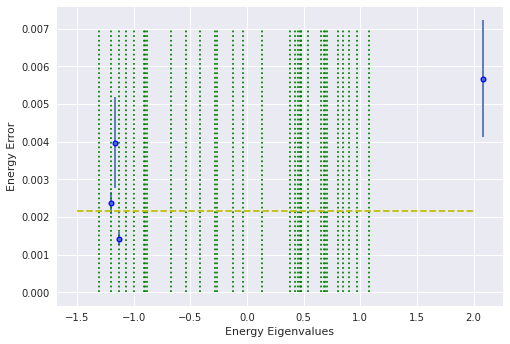

In [53]:




#plot energy errors with horizontal and vertical reference for comparison
plt.plot(filling+e[0], avg_eng_er, 'b.', markersize=12)
plt.errorbar(filling+e[0], avg_eng_er, yerr = se_eng_er, fmt='.')
plt.vlines(x = e, ymin = 0, ymax = 0.007, color = 'g', linestyle = 'dotted')
plt.hlines(y = 0.00216992723025266, xmin = -1.5, xmax = 2, color = 'y', linestyle = 'dashed')
plt.xlabel('Energy Eigenvalues')
plt.ylabel('Energy Error')
plt.show()

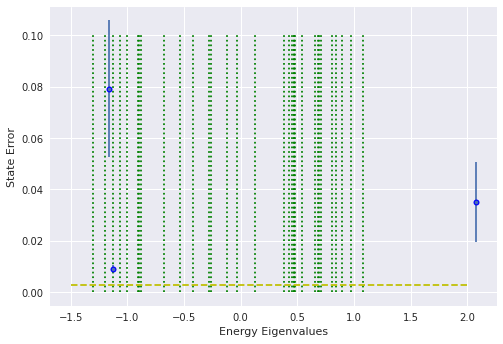

In [57]:
#plot energy errors with horizontal and vertical reference for comparison
plt.plot(filling[1:4]+e[0], avg_sta_er[1:4], 'b.', markersize=12)
plt.errorbar(filling[1:4]+e[0], avg_sta_er[1:4], yerr = se_sta_er[1:4], fmt='.')
plt.vlines(x = e, ymin = 0, ymax = 0.1, color = 'g', linestyle = 'dotted')
plt.hlines(y = 0.002922604191931355, xmin = -1.5, xmax = 2, color = 'y', linestyle = 'dashed')
plt.xlabel('Energy Eigenvalues')
plt.ylabel('State Error')
plt.show()